<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#The-game-of-minesweeper" data-toc-modified-id="The-game-of-minesweeper-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The game of minesweeper</a></span></li><li><span><a href="#The-deductive-solvers" data-toc-modified-id="The-deductive-solvers-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>The deductive solvers</a></span><ul class="toc-item"><li><span><a href="#The-Simple-solver" data-toc-modified-id="The-Simple-solver-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>The Simple solver</a></span></li><li><span><a href="#The-Local-solver" data-toc-modified-id="The-Local-solver-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>The Local solver</a></span></li><li><span><a href="#The-Global-solver" data-toc-modified-id="The-Global-solver-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>The Global solver</a></span></li></ul></li><li><span><a href="#The-probability-map" data-toc-modified-id="The-probability-map-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>The probability map</a></span></li><li><span><a href="#The-guessing-function" data-toc-modified-id="The-guessing-function-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>The guessing function</a></span></li><li><span><a href="#Minesweeper-solver-user-interface" data-toc-modified-id="Minesweeper-solver-user-interface-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Minesweeper solver user interface</a></span><ul class="toc-item"><li><span><a href="#Tips-for-use" data-toc-modified-id="Tips-for-use-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Tips for use</a></span></li><li><span><a href="#The-code" data-toc-modified-id="The-code-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>The code</a></span></li></ul></li><li><span><a href="#Future-development" data-toc-modified-id="Future-development-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Future development</a></span></li></ul></div>

# Introduction

This document records the development to date of a program for solving minesweeper as successfully as possible. It also explains the maths and methodology used, and outlines plans for future development.

At the current time, this solver is able to win 47% of advanced minesweeper games.

Much of this document is devoted to explaining how the solvers used work, and why this design was chosen. **If you wish to see the solvers in action, and the code behind them, please skip to section 6.2, and run the code cell.** [Click here](#Minesweeper-solver-user-interphase)

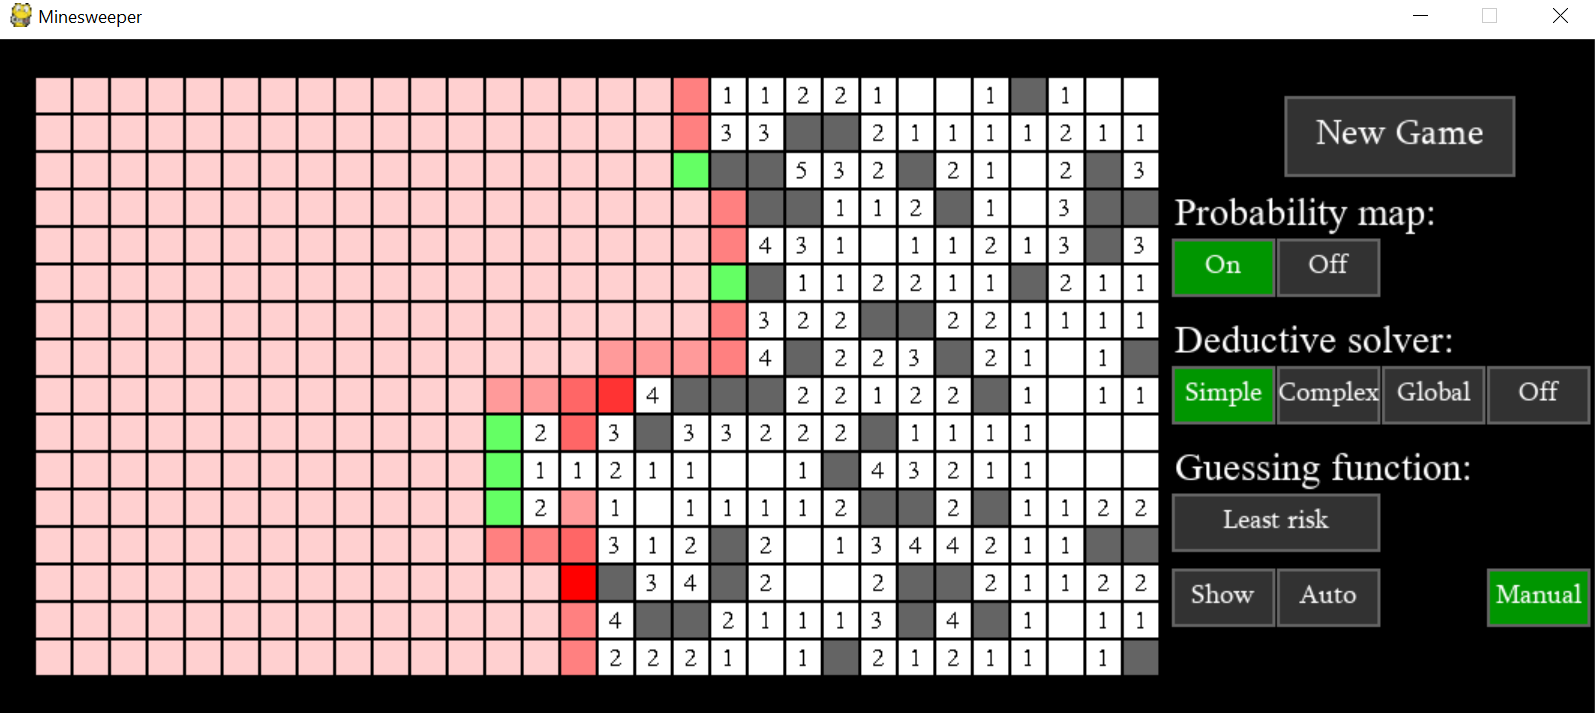

The aims of this project are:

1. Create a playable minesweeper game using pygame.
2. Develop solving functions capable of identifying squares as either definitely mines, or definitely safe. (Deductive Solvers).
3. Develop functions for finding the true probability of each square containing a mine.
4. Use the pygame interface to make these probabilities clearly visible to the user.
5. Set the game up to play autonomously, and record information about completed games in a database.
6. Use this recorded data to train an algorithm to make guesses when no certainties are available. These guesses should maximise the chance of finally winning the game.
7. Investigate and report properties of the developed solver (e.g. What fraction of minesweeper games are winnable? What  principles could a human player adopt to mimic the success of this solver?)

Section 2 outlines the minesweeper game built and used for this project. Sections 3, 4 and 5, deal with different features which have been developed to solve aspects of the minesweeper game. Section 6 contains a user interface designed to demonstrate these features in action. Section 7 sets out plans to use a neural network to develop a new and improved guessing function, to be used as part of this solver.

# The game of minesweeper

For this project, a game of minesweeper was built in python, in order to facilitate development of a minesweeper solver. The type of minesweeper game chosen was the advanced-mode of modern minesweeper games.

These games have a grid of 30x16 squares with 99 mines distributed randomly over those squares. The aim of the game is to clear all squares which do not contain mines without, at any point, clicking on a mine. Each clicked square reveals the number of mines to which it is adjacent. The player must use this information to progressively clear the grid.

Unlike older games of minesweeper, modern versions do not allow the player to lose on their first click. Mines are distributed after this click to ensure none are on the first square clicked. The most modern versions also guarantee that there are no mines on squares immediately surrounding the first click, so that the player starts with a large enough range of information that deductions may be possible. Both of these features have been build into the minesweeper game developed for this project.

Initially, it was possible for the player as well as the automatic solvers to identify mines in the user interface. However, as the identified mines are used in creating the probability map generated by the global solver, inaccurately identified mines led to computer errors when creating this map. Since then, only the automatic solvers have been able to identify known mines.

# The deductive solvers

Deductive solvers are functions which identify squares within the minesweeper grid as being either definitely mines, or definitely not mines. These squares are then either clicked on, or added to the list of identified mines. These solvers are called deductive because they never take any risk, but only act on what they can identify with certainty.

Three deductive solvers are used in this code, the Simple solver, the Local solver, and the Global solver. They are designed to work together to make progress as efficiently as possible.

## The Simple solver

The first solver called is the Simple solver. It is much faster and less memory intensive than the other two, but also less complete.

For every square in the grid which has been clicked, and is adjacent to unknown squares (which have not been clicked or identified as mines), it checks to see whether all mines adjacent to that square have already been identified, or the adjacent unknowns is equal to the unidentified mines. In the first case, all remaining adjacent unknown squares must not be mines and are clicked. In the second, all adjacent unknowns must contain mines, and are added to the list.

This solver is run repeatedly until it ceases to make progress. Then the Local solver is called.

## The Local solver

The Local solver is part of the local_probs function. It works by breaking the minesweeper grid down into separable clumps, and then considering all possible ways that mines could be distributed within those clumps that would be consistent with the available information. It then checks these possibilities to see if there are squares within these clumps that are either always mines, or never mines. If such squares are found, they are then either clicked, or recorded as mines.

The local solver uses the recursive function find_clump to find separable areas of the grid. The key feature of the identified clumps is that clicked squares (showing numbers) are never adjacent to unknowns from more than 1 clump. This means that the possible mine arrangements for each clump are independent of one another (except for the effect of total mine number, which is only considered by the Global solver).

Separating the grid into clumps is in this way is important as the time taken to find possible mine arrangements within a set of squares rises polynomially with the number of squares. The combinations function finds all possible mine arrangements within each clump. These possibilities are used to identify squares that are either definitely, or definitely not mines. If these are identified, the updated grid, and list of known mines is passed back to the Simple solver. If none are identified, the lists of possible mine arrangements are passed to the Global solver.

## The Global solver

The role of the Global solver is to consider the clump distributions provided by the local solver, and compare this to the total number of unidentified mines within the grid. It then works out which of these distributions are still possible, and which are probable.

If the global solver discounts locally possible mine distributions, it may be able to identify squares as either definitely mines, or definitely not mines. If so, these squares are either clicked, or added to the list of identified mines, and the Simple solver is called.

Otherwise, the global solver uses the possible local distributions as well as the total mine number, and total number of unknown squares to calculate the probability of being a mine for each unknown square on the grid.

# The probability map

As well as identifying squares that are either definitely mines, or definitely not mines, the global solver is also able to produce of definitive probability map, for the chance that each square in the grid is a mine.

If we had the set of all possible mine distributions for the entire grid, then we could calculate the probability that a particular square contained a mine by finding the proportion of those distributions in which that square was one containing a mine. Given the set of possible distributions for one clump, we can perform a similar calculation. But to do so, we will need to weight each distribution by the probability that the clump contains the number of mines listed in that distribution. This weight is equal to the number of distributions of the rest of the grid which contain exactly the number of mines not contained in the considered local distribution.

From the local solver, we already have the sets of all possible mine distributions within each clump. However, only those unknown squares which are adjacent to clicked squares are divided into clumps. To account for those unknown squares which are not in a clump, we need to find the number of ways in which different numbers of mines can be distributed within these squares. Fortunately, as we have to other information about these square to take into account, this is a simple N choose K problem. These problems are efficiently solved by the scipy.specials.comb function.

The probabilities calculated by this method are the same as those that would be found by considering all possible mine distributions over the entire grid, and finding the proportion in which each square is a mine. However, by using the separability of the clumps identified by the local solver, these probabilities can be found far more efficiently.

These probabilities are used to produce a probability map which can be referred to by a user to assist their decision making. It is also very valuable information for an automated guessing function.

# The guessing function

The deductive solvers discussed in section 3 are between them able to identify and respond to every possible situation in which a square can be determined with certainty to be either a mine or not a mine. However situations often arise in games of minesweeper in which these certainties are not possible, and it is necessary to make guesses. guessing functions are responsible for taking risks, and are designed to be called when all definitely safe moves have been exhausted.

At present there is only one guessing function included in this minesweeper solver, this is the simple_guess function. A second far more sophisticated guessing function is currently being developed (details can be found in section 7).

The simple_guess function function (called least risk in the UI), works by simply finding the square with the lowest chance of being a mine listed in the probability map. In the event of a tie, it chooses the square closest to the first square clicked in the game.

The simple_guess function is very simple, and makes reasonable guesses in most situations. However, it does not take any account of the potential information gain offered by different choices of click, or other potential considerations of long term strategy. For this reason, work is currently underway to train a neural network, to predict the chance of finally winning a minesweeper game given different possible clicks. Ultimately this will hopefully provide a more sophisticated and more successful guessing function.

# Minesweeper solver user interface

The following code runs the minesweeper solver in a user friendly pygame window. Several settings are available to allow user to experiment and see how the minesweeper solving functions work.

## Tips for use

- To start the game, just click on any square in the grid.
- If the probability map is turned on, then the chance that each square is a mine is displayed in the bottom right.
- If the guessing function is set to Auto, then the program will play automatically until the game is either won or lost. Otherwise the program will never make a move with any risk of loosing the game.
- The deductive solvers will instantly clear all the squares they know to be safe, but never take any risks.
- The Global deductive solver uses the same function that creates the probability map. It is the most powerful, and finishes most games extremely quickly.
- The Simple deductive solver only makes the most obviously safe moves, based on the numbers immediately adjacent to each square.
- To see the speed and efficiency of this solver, set the deductive solver to Global, and the guessing function to Auto. The game will be over almost immediately.
- A much less efficient option (which looks a lot more impressive) is to turn off the deductive solvers, and watch as the guessing function slowly sweeps across the grid.

## The code

In [7]:
import numpy as np
from scipy.special import comb
import pygame
from copy import deepcopy

Dwidth=1065
Dheight=450

pygame.init()

window=pygame.display.set_mode((Dwidth,Dheight))
pygame.display.set_caption('Minesweeper')

class Button():
    'UI button for pygame.'
    def __init__(self,x,y,width,height,text=False,font_size=18):
        self.font_size=font_size
        self.x=x
        self.y=y
        self.width=width
        self.height=height
        self.text=text
    def draw(self,win,color=(50,50,50)):
        pygame.draw.rect(win,(100,100,100),(self.x-2,self.y-2,self.width+4,self.height+4),0)
        pygame.draw.rect(win,color,(self.x,self.y,self.width,self.height),0)
        if self.text:
            font=pygame.font.SysFont('Sylfaen',self.font_size)
            text=font.render(self.text,True,(255,255,255))
            win.blit(text,((self.x+(self.width-text.get_width())/2),(self.y+(self.height-text.get_height())/2)))
    def is_over(self,pos):
        if pos[0]>self.x and pos[0]<(self.x+self.width):
            if pos[1]>self.y and pos[1]<(self.y+self.height):
                return True
        return False

class simple_sqr:
    '''Used for creating a copy of known information about the grid, and considering
    hypothetical mine arangements'''
    def __init__(self,coord,num,adj_unk,adj_IDed):
        self.coord=coord
        self.num=num
        self.adj_unk=adj_unk
        self.adj_IDed=adj_IDed

class square():
    '''The squares of the minesweeper grid.'''
    def __init__(self, x,y,width=25,height=25):
        self.width=width
        self.height=height
        self.grid_x=x
        self.grid_y=y
        self.pos_x=25+width*x
        self.pos_y=25+height*y
        self.mine=False
        self.clicked=False
        self.coord=(self.grid_x,self.grid_y)
        self.adj_unk=9
        self.adj_IDed=0
    def draw(self,win,color=(100,100,255)):
        if not self.clicked:
            pygame.draw.rect(win,color,(self.pos_x+1,self.pos_y+1,self.width-2,self.height-2),0)
    def get_number(self,grid):
        global x,y
        if self.mine:
            self.num='X'
        else:
            self.num=0
            for i in range(self.grid_x-1,self.grid_x+2):
                for j in range(self.grid_y-1,self.grid_y+2):
                    if -1<i<x and -1<j<y:
                        if grid[(i,j)].mine:
                            self.num=self.num+1
        font=pygame.font.SysFont('timesnewroman',17)
        self.surf=pygame.Surface([self.width-2,self.height-2])
        self.surf.fill((255,255,255))
        if self.num!=0:
            num_surf=font.render(str(self.num),0,(0,0,0))
            pos_x=int((self.width-2-num_surf.get_width())/2)
            pos_y=int((self.height-2-num_surf.get_height())/2)
            self.surf.blit(num_surf,(pos_x,pos_y))
    def show_num(self,win):
        win.blit(self.surf,(self.pos_x+1,self.pos_y+1))
    def is_over (self,pos):
        if pos[0]>self.pos_x and pos[0]<(self.pos_x+self.width):
            if pos[1]>self.pos_y and pos[1]<(self.pos_y+self.height):
                return True
        return False
    def count_adj(self,grid,known_mines):
        self.adj_unk=set()
        self.adj_IDed=0
        for i in range(self.grid_x-1,self.grid_x+2):
            for j in range(self.grid_y-1,self.grid_y+2):
                if -1<i<x and -1<j<y and (i,j) in known_mines:
                    self.adj_IDed=self.adj_IDed+1
                elif -1<i<x and -1<j<y and not grid[(i,j)].clicked:
                    self.adj_unk.add((i,j))


def blank_grid(x,y):
    '''Creates a dictionary of possible positions. All false.'''
        #create space lables
    keys=list()
    for i in range(0,x):
        for j in range (0,y):
            keys.append((i,j))
    #create empty grid
    mine_grid={}
    for i in keys:
        mine_grid[i]=square(i[0],i[1])
    return mine_grid

def on_grid(pos):
    '''Checks if a cursor possition is over the mine grid. Used to speed up UI'''
    global x,y
    if pos[0]<25 or pos[0]>25*(x+1):
        return False
    elif pos[1]<25 or pos[1]>25*(y+1):
        return False
    else: return True

def lay_mines(mine_grid,mines,click):
    '''Randomly lays mines within grid. Leaves space surrounding first click, inline
    with modern minesweeper games.'''
    #identify safe squares around first click
    safes=list()
    for i in range(click[0]-1,click[0]+2):
        for j in range(click[1]-1,click[1]+2):
            safes.append((i,j))
    #select random set from grid spaces not in safes
    possible=list(mine_grid.keys())
    for i in safes:
        if i in possible:
            possible.remove(i)
    np.random.shuffle(possible)
    mine_spaces=possible[0:mines]
    for i in mine_spaces:
        mine_grid[i].mine=True
    return mine_grid

def click(grid,coord):
    '''This function is called whenever a square is clicked (manually or automaticaly).
    It reveals apropriate squares, and checks if the game has been won or lost.'''
    if not grid[coord].clicked:
        grid[coord].clicked=True
        global x, y, window, stage, front, known_mines, prob_dict
        grid[coord].count_adj(grid,known_mines)
        if coord in front: front.remove(coord)
        grid[coord].show_num(window)
        if grid[coord].num=='X':
            stage=9
            print('You lose')
            if coord in prob_dict:
                print(coord,'prob:',prob_dict[coord])
            for key in grid:
                if grid[key].mine:
                    grid[key].show_num(window)
        elif grid[coord].num==0:
            for i in range(coord[0]-1,coord[0]+2):
                for j in range(coord[1]-1,coord[1]+2):
                    if -1<i<x and -1<j<y and not grid[(i,j)].clicked:
                        click(grid,(i,j))
        else:
            for i in range(coord[0]-1,coord[0]+2):
                for j in range(coord[1]-1,coord[1]+2):
                    if -1<i<x and -1<j<y and not grid[(i,j)].clicked and (i,j) not in known_mines:
                        front.add((i,j))
                        
                        
def solving(grid,known_mines,initial=False):
    '''The first stage of this function (within the Done loop) looks for squares that can be
    identified as definitely or defiely not mines, and loops until it stops making progress.
    The second stage (within the completely_Done loop) runs a semi-local probability function
    which can identify squares as either definitely mines or definitely not mines, as well as
    listing possible local distributions.
    The third stage (within the perfectly_Done) loop combines these local distributions with
    the total number of mines and number of unseen squares remaining to obtain definitive
    probabilities for every unclicked square.'''
    global stage
    
    perfectly_Done=False
    while not perfectly_Done:
        perfectly_Done=True
        
        completely_Done=False
        while not completely_Done:
            completely_Done=True
            
            Done=False
            while not Done:
                Done=True
                #Simple solver
                for key in grid:
                    if grid[key].clicked and len(grid[key].adj_unk)>0 and grid[key].num!='X':
                        grid[key].count_adj(grid,known_mines)
                        if solve_level>0:
                            if (grid[key].num)-(grid[key].adj_IDed)==0:
                                for i in range(key[0]-1,key[0]+2):
                                    for j in range(key[1]-1,key[1]+2):
                                        if -1<i<x and -1<j<y and not grid[(i,j)].clicked and (i,j) not in known_mines:
                                            Done=False
                                            click(grid,(i,j))
                            elif (grid[key].num)-(grid[key].adj_IDed)-len(grid[key].adj_unk)==0:
                                for i in range(key[0]-1,key[0]+2):
                                    for j in range(key[1]-1,key[1]+2):
                                        if -1<i<x and -1<j<y and not grid[(i,j)].clicked:
                                            Done=False
                                            known_mines.add((i,j))
                                            if (i,j) in front:
                                                front.remove((i,j))
                        elif prob_mapping or guess_use>0:
                            if (grid[key].num)-(grid[key].adj_IDed)-len(grid[key].adj_unk)==0:
                                for i in range(key[0]-1,key[0]+2):
                                    for j in range(key[1]-1,key[1]+2):
                                        if -1<i<x and -1<j<y and not grid[(i,j)].clicked:
                                            Done=False
                                            known_mines.add((i,j))
                                            if (i,j) in front:
                                                front.remove((i,j))
            #Local clump solver                
            prob_dict,distributions,clumps=local_probs(grid,front,known_mines,mines)
            if solve_level>1:
                for sqr in prob_dict:
                    if prob_dict[sqr]==0:
                        click(grid,sqr)
                        completely_Done=False
                    if prob_dict[sqr]==1:
                        known_mines.add(sqr)
                        front.remove(sqr)
                        completely_Done=False
                        
        #Global solver
        background=set()
        ranges=[{} for i in range(len(distributions))]
        #ranges lists a dictionary for each clump. These dictionaries have a total number of
        #mines for that clump as key, and a number of ways consistant with that as contents.
        for key in grid:
            if not grid[key].clicked:
                background.add(key)
        for clump in clumps:
            for sqr in clump:
                background.remove(sqr)
        for sqr in known_mines:
            if sqr in background:
                background.remove(sqr)
        for i,dists in enumerate(distributions):
            for dist in dists:
                if len(dist) not in ranges[i]:
                    ranges[i][len(dist)]=1
                else:
                    ranges[i][len(dist)]=ranges[i][len(dist)]+1
        bg_range={}
        if len(background)>0:
            surround_range=clump_permutator(ranges.copy())
            for tup in surround_range:
                if (mines-len(known_mines)-tup[0])>=0:
                    if mines-len(known_mines)-tup[0] not in bg_range:
                        bg_range[mines-len(known_mines)-tup[0]]=tup[1]
                    else:
                        bg_range[mines-len(known_mines)-tup[0]]=bg_range[mines-len(known_mines)-tup[0]]+tup[1]
            if len(bg_range)==0:
                bg_range[mines-len(known_mines)]=1
            #Now use this dictionary to calcute probability for background squares.
            total_ways=0
            for num in bg_range:
                total_ways=total_ways+bg_range[num]
            prob=0
            for num in bg_range:
                prob=prob+((num*bg_range[num])/(len(background)*total_ways))
            for sqr in background:
                prob_dict[sqr]=prob
        #calculate new probabilities for each clump taking into account global mine distribution.
        for i,clump in enumerate(clumps):
            multipliers={}
            total_ways=0
            for num in ranges[i]:
                multipliers[num]=0
                if len(clumps)>1:
                    other_clumps=clump_permutator(ranges[:i]+ranges[i+1:])
                    if len(other_clumps)==0: print('Error: other_clumps empty.')
                    for possible in other_clumps:
                        if possible[0]+num<=mines-len(known_mines):
                            bg_mines=mines-len(known_mines)-possible[0]-num
                            multipliers[num]=multipliers[num]+possible[1]*int(comb(len(background),bg_mines))
                else:
                    bg_mines=mines-len(known_mines)-num
                    multipliers[num]=multipliers[num]+int(comb(len(background),bg_mines))
                total_ways=total_ways+(ranges[i][num]*multipliers[num])
            if total_ways==0:
                print('Error:total_ways=0',clump,distributions[i])
                print('clump ',i,' of ',len(clumps))
                print('ranges',ranges[i])
                print('multipliers',multipliers)
                print('clumps:',clumps)
            for sqr in clump:
                prob_dict[sqr]=0
            for dist in distributions[i]:
                num=len(dist)
                prob=multipliers[num]/total_ways
                if not 0<=prob<=1:
                    print ('Error: prob ',prob,' out of range.')
                    print ('ways, total ways',multipliers[num],total_ways)
                    print (dist)
                    prob=0
                for sqr in dist:
                    prob_dict[sqr]=prob_dict[sqr]+prob
        if solve_level>2:
            for sqr in prob_dict:
                if prob_dict[sqr]==0:
                    click(grid,sqr)
                    perfectly_Done=False
                if prob_dict[sqr]==1:
                    known_mines.add(sqr)
                    perfectly_Done=False
        
    if sum([sqr.clicked for sqr in grid.values()])==((x*y)-mines) and stage<9:
        stage=8
        print('you win')
    return prob_dict
        
def clump_permutator(ranges):
    'This function calculates a ranges dictionary for squares within a local area from all other clumps'
    calc_range1=[]
    for r_dict in ranges:
        if len(calc_range1)==0:
            for num in r_dict:
                calc_range1.append((num,r_dict[num]))
        else:
            calc_range2=[]
            for num in r_dict:
                for tup in calc_range1:
                    calc_range2.append((num+tup[0],r_dict[num]*tup[1]))
            calc_range1=calc_range2.copy()
    return calc_range1      #List of tuples.(num of mines in clump, num of consistent permutations)

def find_clump(clear_new, clear_front, clump=[set(),set()]):
    '''This function will identify the set of simple squares in clear_front which belong to
    the same area clump. clear squares added to clump[0]. Unknowns added to clump[1]. Once
    added to clump, squares are removed from set clear_front.'''
    for clear in clear_new:
        clump[0].add(clear)
        for unk in clear.adj_unk:
            clump[1].add(unk)
    clear_new=set()
    for clear in clear_front:
        for unk in clear.adj_unk:
            if unk in clump[1]:
                clear_new.add(clear)
    if len(clear_new)>0:
        for clear in clear_new:
            clear_front.remove(clear)
        clump=find_clump(clear_new,clear_front,clump)
    return clump

def hypothetical_solve(clump,dist):
    '''A simplified solver designed to be called by the combinations function'''
    Done=False
    n=0
    while not Done and n<200:
        n=n+1
        if n==200: print('loop out')   #Limit used to prevent infinite loops. Should never be reached.
        finish0=set()
        Done=True
        for sqr in clump[0]:
            if len(sqr.adj_unk)>0:
                if sqr.num-sqr.adj_IDed==0:
                    Done=False
                    finish0.add(sqr)
                    for unk in sqr.adj_unk:
                        for sqr2 in clump[0]:
                            if sqr2!=sqr:
                                if unk in sqr2.adj_unk:
                                    sqr2.adj_unk.remove(unk)
                        if unk in clump[1]:
                            clump[1].remove(unk)
                if sqr.num-sqr.adj_IDed==len(sqr.adj_unk):
                    Done=False
                    finish0.add(sqr)
                    for unk in sqr.adj_unk:
                        dist.add(unk)
                        for sqr2 in clump[0]:
                            if sqr2!=sqr:
                                if unk in sqr2.adj_unk:
                                    sqr2.adj_unk.remove(unk)
                                    sqr2.adj_IDed=sqr2.adj_IDed+1
                        if unk in clump[1]:
                            clump[1].remove(unk)
        for sqr in finish0:
            clump[0].remove(sqr)

def combinations(clump,distributions,dist,initial=False):
    '''This function takes a clump of visible unknowns, and the adjacent squares which show
    information about them, and returns a list of all possible mine distributionsin the clump.
    clump[0] is a list of cleared squares bordering unknowns.
    clump[1] is a list of coords for all unknowns in the clump.
    dist is the distribution currently being developped.
    distributions is the list to which all completed possible distibutions are added.'''
    possible=True           #This section checks if considered clump arangement is possible
    for sqr in clump[0]:
        if sqr.adj_IDed>sqr.num:
            possible=False
        if sqr.num-sqr.adj_IDed>len(sqr.adj_unk):
            possible=False
    if possible:            #add distribution to list if it is complete
        if len(clump[1])==0:
            distributions.append(dist)
        else:
            finish0=set()       #forget squares with 0 adjacent unknowns
            for sqr in clump[0]:
                if len(sqr.adj_unk)==0:
                    finish0.add(sqr)
            for sqr in finish0:
                clump[0].remove(sqr)
            clump1=deepcopy(clump)
            trying=clump1[1].pop()      #Pick any unknown square in the clump as trying
            clump2=deepcopy(clump1)
            
            #assume trying is mine
            dist1=dist.copy()
            dist1.add(trying)
            for sqr in clump1[0]:
                if trying in sqr.adj_unk:
                    sqr.adj_unk.remove(trying)
                    sqr.adj_IDed=sqr.adj_IDed+1
            hypothetical_solve(clump1,dist1)          #Solve based on assumption
            combinations(clump1,distributions,dist1)  
            
            #assume trying is not a mine
            dist2=dist.copy()
            for sqr in clump2[0]:
                if trying in sqr.adj_unk:
                    sqr.adj_unk.remove(trying)
            hypothetical_solve(clump2,dist2)          #Solve based on assumption
            combinations(clump2,distributions,dist2)
        if initial:
            return distributions

def local_probs(grid,front,known_mines,mines):
    '''This function splits the grid into independant clumps, and then uses the combinations
    function to find all possible distributions of mines in these clumps. It returns these
    distributions as well as probabilities based on them.
    Note that the probabilities returned by this function, are based only on possible
    distributions within an individual clump. To find true global probabilities, other clumps,
    total mine number, and total unknown squares must be taken into account. (See solving)'''
    clear_front=set()
    prob_dict={}
    for key in grid:
        if grid[key].clicked and len(grid[key].adj_unk)>0:
            clear_front.add(simple_sqr(key,grid[key].num,grid[key].adj_unk,grid[key].adj_IDed))
    clear_front2=clear_front.copy()
    clumps=[]
    while len(clear_front2)>0:
        start=clear_front2.pop()
        clumps.append(find_clump({start},clear_front2,[set(),set()]))
    distributions=[0]*len(clumps)
    for i in range(0,len(clumps)):
        distributions[i]=combinations(clumps[i],[],set(),initial=True)
        ways=len(distributions[i])
        if ways==0: print ('ways==0 error')
        for sqr in clumps[i][1]:
            n=0
            for dist in distributions[i]:
                if sqr in dist:
                    n=n+1
            prob_dict[sqr]=float(n)/float(ways)
    unk_clumps=[]
    for clump in clumps:
        unk_clumps.append(clump[1])
    return prob_dict,distributions,unk_clumps

def start_game(x=30,y=16):
    '''Resets global variables, and creates new grid. 30x16 is default, as a standard
    advanced minesweeper grid.'''
    global known_mines,front,prob_dict,stage,run,grid
    known_mines=set()
    front=set()
    prob_dict={}
    stage=0
    grid=blank_grid(x,y)

def simple_guess(prob_dict,first_guess):
    '''This function returns square with lowest chance of being a mine. In the case of a tie,
    it picks the option closest to the first square clicked.'''
    min_prob=prob_dict[min(prob_dict,key=prob_dict.get)]
    options=[]
    for sqr in prob_dict:
        if prob_dict[sqr]==min_prob:
            options.append(sqr)
    #Pick the option closest to the first square clicked
    if len(options)>1:
        sqr=min(options,key=lambda option:abs(option[0]-first_guess[0])+abs(option[1]-first_guess[1]))
    else:sqr=options[0]
    return sqr

#define grid paramaters
mines=99
x=30
y=16

hovering=None
run=True
move0=None
guess=None

start_game(x,y)

solve_level=1
prob_mapping=True
guess_func=1
guess_use=0

label_font=pygame.font.SysFont('timesnewroman',26)
readout_font=pygame.font.SysFont('timesnewroman',18)
solver_label=label_font.render('Deductive solver:',True,(255,255,255))
window.blit(solver_label,(785,185))
prob_label=label_font.render('Probability map:',True,(255,255,255))
window.blit(prob_label,(785,100))
guessing_label=label_font.render('Guessing function:',True,(255,255,255))
window.blit(guessing_label,(785,270))

new_game=Button(860,40,150,50,text='New Game',font_size=24)

solv_off=Button(995,220,65,35,text='Off')
solv_1=Button(785,220,65,35,text='Simple')
solv_2=Button(855,220,65,35,text='Local')
solv_3=Button(925,220,65,35,text='Global')
solv_buttons=[solv_off,solv_1,solv_2,solv_3]

prob_off=Button(855,135,65,35,text='Off')
prob_on=Button(785,135,65,35,text='On')

min_risk=Button(785,305,135,35,text='Least risk')
guess_off=Button(995,355,65,35,text='Manual')
guess_show=Button(785,355,65,35,text='Show')
guess_auto=Button(855,355,65,35,text='Auto')
guess_buttons=[guess_off,guess_show,guess_auto]

def redraw(hovering):
    global known_mines
    
    #Draw control buttons
    for i,button in enumerate(solv_buttons):
        if i==solve_level:
            button.draw(window,(0,150,0))
        else: button.draw(window)
    
    if prob_mapping:
        prob_on.draw(window,(0,150,0))
        prob_off.draw(window)
    else:
        prob_off.draw(window,(0,150,0))
        prob_on.draw(window)
    
    if guess_func==1 and guess_use>0: min_risk.draw(window,(0,150,0))
    else: min_risk.draw(window)

    for i,button in enumerate(guess_buttons):
        if i==guess_use:
            button.draw(window,(0,150,0))
        else: button.draw(window)
    
    if hovering=='new_game':
        new_game.draw(window,(100,100,100))
    else: new_game.draw(window)
    
    #Draw information readout in bottom right.
    pygame.draw.rect(window,(0,0,0),(785,400,300,50),0)
    if type(hovering)==tuple and prob_mapping and stage<8:
        if hovering in known_mines:
            readout=readout_font.render('Chance of mine: 100%',True,(255,255,255))
            window.blit(readout,(785,400))
        elif hovering in prob_dict:
            num_string='%.2f' % (round(prob_dict[hovering],4)*100)
            readout=readout_font.render('Chance of mine: '+num_string+'%',True,(255,255,255))
            window.blit(readout,(785,400))
    elif stage==8:
        readout=readout_font.render('You win',True,(255,255,255))
        window.blit(readout,(785,400))
    elif stage==9:
        readout=readout_font.render('You lose',True,(255,255,255))
        window.blit(readout,(785,400))
    
    #Draw mine grid.
    if stage==0:    
        for key in grid:
            if key==hovering:
                grid[key].draw(window,(150,150,255))
            else: grid[key].draw(window)
    elif stage==1 or stage==8:  
        for key in grid:
            if not grid[key].clicked:
                if key==guess and guess_use>0:
                    grid[key].draw(window,(255,255,0))
                elif key==hovering:
                    grid[key].draw(window,(150,150,255))
                elif key in known_mines and prob_mapping:
                    grid[key].draw(window,(100,100,100))
                elif key in prob_dict and prob_mapping:
                    if prob_dict[key]==0:
                        grid[key].draw(window,(100,255,100))
                    else:
                        grid[key].draw(window,(255,255-int(255*prob_dict[key]),255-int(255*prob_dict[key])))
                else: grid[key].draw(window)
                
while run:
    redraw(hovering)
    pygame.display.update()
    pygame.time.delay(25)
    pos=pygame.mouse.get_pos()
    
    #Automatic guessing (if turned on).
    if 0<stage<8 and not guess:
        if guess_func==1: guess=simple_guess(prob_dict,move0)
        else: print('Error: Selected guess_func not availible')
        if guess_use==2:
            click(grid,guess)
            if stage<8:
                prob_dict=solving(grid,known_mines)
                guess=None
    
    for event in pygame.event.get():
        if event.type==pygame.QUIT:
            run=False
        
        if event.type==pygame.MOUSEMOTION:
            if on_grid(pos):
                for key in grid:
                    if grid[key].is_over(pos):
                        hovering=grid[key].coord
            elif new_game.is_over(pos):
                hovering='new_game'
            else: hovering=None

        if event.type==pygame.MOUSEBUTTONDOWN and pygame.mouse.get_pressed()[0]:
            if on_grid(pos):
                if stage==0:
                    for key in grid:
                        if grid[key].is_over(pos):
                            move0=key
                            grid=lay_mines(grid,mines,key)
                            stage=1
                            for key2 in grid:
                                grid[key2].get_number(grid)
                            click(grid,key)
                            prob_dict=solving(grid,known_mines)
                            guess=None
                if stage==1:
                    for key in grid:
                        if grid[key].is_over(pos):
                            if not grid[key].clicked:
                                click(grid,key)
                                if stage<8:
                                    prob_dict=solving(grid,known_mines)
                                    guess=None
            elif prob_on.is_over(pos): prob_mapping=True
            elif prob_off.is_over(pos): prob_mapping=False
            elif new_game.is_over(pos): start_game()
            elif min_risk.is_over(pos): guess_func=1
            else:
                for i,button in enumerate(guess_buttons):
                    if button.is_over(pos): guess_use=i
                for i,button in enumerate(solv_buttons):
                    if button.is_over(pos): solve_level=i

pygame.display.quit()

# Future development

The deductive solvers used in this code are between them able to respond to all cases in which a square is either definitely a mine, or definitely not a mine. Their effectiveness cannot be improved upon, and although it may be possible to improve their efficiency, such improvements would be small and incremental.

Future improvements will therefore focus on the guessing function, and the user interface.

A new guessing function is currently being developed which will hopefully be able to improve on the performance of the simple_guess function currently being used. This function is based on using a PyTorch convolutional neural network (CNN), to develop a function to estimate the probability of finally winning a game following the clicking of a particular unknown squares. The function will use a probability map of the grid centered on clicked square to make this prediction.

In order to begin training the CNN, thousands of games of minesweeper are being run automatically using the current guessing function. Records are being made of the state of the grid every time a guess is made, and whether or not the game was ultimately won. This data will be used to prime the CNN, through an initial round of training. The CNN's predictions will then be used to make guesses in future minesweeper games, and the results will be used to further train the CNN.